In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import cv2

In [2]:
directory='C:/Users/Aditya/Documents/GitHub/Covid-19-Diagnosis-from-Lung-CT-Scans/Dataset'
path_covid_positive_cases=os.path.join('C:/Users/Aditya/Documents/GitHub/Covid-19-Diagnosis-from-Lung-CT-Scans/Dataset/CT_COVID/')
path_covid_negative_cases=os.path.join('C:/Users/Aditya/Documents/GitHub/Covid-19-Diagnosis-from-Lung-CT-Scans/Dataset/CT_NonCOVID/')

print('Number of Positive Covid-19 Samples: {}'.format(len(os.listdir(path_covid_positive_cases))))
print('Number of Negative Covid-19 Samples: {}'.format(len(os.listdir(path_covid_negative_cases))))

Number of Positive Covid-19 Samples: 349
Number of Negative Covid-19 Samples: 397


In [3]:
positive_covid_images = glob(os.path.join(path_covid_positive_cases,"*.png"))
negative_covid_images = glob(os.path.join(path_covid_negative_cases,"*.png"))
negative_covid_images.extend(glob(os.path.join(path_covid_negative_cases,"*.jpg")))

In [4]:
covid = {'class': 'CT_COVID','path': path_covid_positive_cases,'images': positive_covid_images}
non_covid = {'class': 'CT_NonCOVID','path': path_covid_negative_cases,'images': negative_covid_images}

In [5]:
subdirs=['CNN/Train/','CNN/Test/']
for subdir in subdirs:
    labeldirs=['CT_COVID','CT_NonCOVID']
    for labeldir in labeldirs:
        newdir=subdir+labeldir 
        os.makedirs(newdir,exist_ok="True")

In [6]:
import shutil
import random

random.seed(69)
test_ratio=0.2

for cases in [covid,non_covid]:
    total_cases=len(cases['images'])
    num_to_select=(int)(total_cases*test_ratio)
    print("No. of Testing",cases['class'],"Samples:",num_to_select)
    #print("Total",cases['class'],"Samples:",total_cases)
    random_files_list=random.sample(cases['images'],num_to_select)
    for files in random_files_list:
        shutil.copy(files,'CNN/Test/'+cases['class'])

No. of Testing CT_COVID Samples: 69
No. of Testing CT_NonCOVID Samples: 79


In [7]:
for cases in [covid,non_covid]:
    images_test_files=os.listdir('CNN/Test/'+cases['class'])
    for images in cases['images']:
        if images.split('\\')[-1] not in images_test_files:
            shutil.copy(images,'CNN/Train/'+cases['class'])

In [8]:
total_train_covid = len(os.listdir('C:/Users/Aditya/Documents/GitHub/Covid-19-Diagnosis-from-Lung-CT-Scans/CNN/Train/CT_COVID'))
total_train_noncovid = len(os.listdir('C:/Users/Aditya/Documents/GitHub/Covid-19-Diagnosis-from-Lung-CT-Scans/CNN/Train/CT_NonCOVID'))
total_test_covid = len(os.listdir('C:/Users/Aditya/Documents/GitHub/Covid-19-Diagnosis-from-Lung-CT-Scans/CNN/Test/CT_COVID'))
total_test_noncovid = len(os.listdir('C:/Users/Aditya/Documents/GitHub/Covid-19-Diagnosis-from-Lung-CT-Scans/CNN/Test/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 280
Train sets images Non COVID: 318
Test sets images COVID: 69
Test sets images Non COVID: 79


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_image_gen = ImageDataGenerator(rescale=1./255)
test_image_gen = ImageDataGenerator(rescale=1./255)

train_dir=os.path.join('C:/Users/Aditya/Documents/GitHub/Covid-19-Diagnosis-from-Lung-CT-Scans/CNN/Train/')
test_dir=os.path.join('C:/Users/Aditya/Documents/GitHub/Covid-19-Diagnosis-from-Lung-CT-Scans/CNN/Test/')

In [11]:
train_generator=train_image_gen.flow_from_directory(train_dir, batch_size=32, class_mode='binary', 
                                                  target_size=(250,250))

Found 598 images belonging to 2 classes.


In [12]:
test_generator=test_image_gen.flow_from_directory(test_dir, batch_size=32, class_mode='binary',
                                               target_size=(250,250))

Found 148 images belonging to 2 classes.


In [13]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(250,250,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 61, 61, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 32)        9

In [15]:
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

history=model.fit(train_generator,steps_per_epoch = train_generator.samples // 32, epochs=20,validation_data=test_generator)

Epoch 1/20
18/18 [==============================] - 15s 732ms/step - loss: 0.8233 - accuracy: 0.4700 - val_loss: 0.6925 - val_accuracy: 0.5338
Epoch 2/20
18/18 [==============================] - 12s 669ms/step - loss: 0.6926 - accuracy: 0.5548 - val_loss: 0.6920 - val_accuracy: 0.5338
Epoch 3/20
18/18 [==============================] - 12s 674ms/step - loss: 0.6894 - accuracy: 0.5654 - val_loss: 0.6835 - val_accuracy: 0.5338
Epoch 4/20
18/18 [==============================] - 12s 671ms/step - loss: 0.6877 - accuracy: 0.6007 - val_loss: 0.6870 - val_accuracy: 0.5878
Epoch 5/20
18/18 [==============================] - 12s 677ms/step - loss: 0.6620 - accuracy: 0.6042 - val_loss: 0.6530 - val_accuracy: 0.6824
Epoch 6/20
18/18 [==============================] - 12s 669ms/step - loss: 0.6548 - accuracy: 0.6237 - val_loss: 0.6288 - val_accuracy: 0.6554
Epoch 7/20
18/18 [==============================] - 12s 671ms/step - loss: 0.5756 - accuracy: 0.7120 - val_loss: 0.6100 - val_accuracy: 0.6351

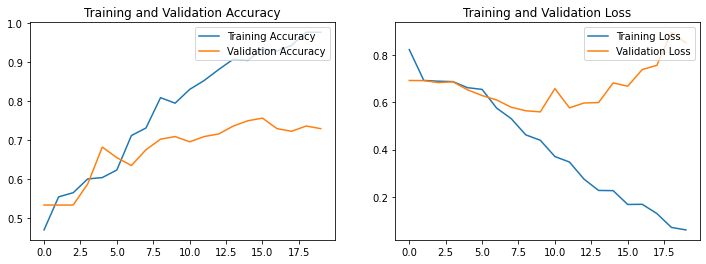

In [16]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
step_size=test_generator.samples//test_generator.batch_size
test_generator.reset()
Y_Pred=model.predict(test_generator,steps=step_size)

4/4 [==============================] - 1s 221ms/step


In [18]:
predictions=[]
y_pred=[]
for pred in Y_Pred:
    if pred<=0.5:
        predictions.append('CT_COVID')
        y_pred.append(0)
    else:
        predictions.append('CT_NonCOVID')
        y_pred.append(1)
filenames=[]
classnames=[]
for i in range(128):
    filenames.append(test_generator.filenames[i])
    classnames.append(test_generator.classes[i])

In [19]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(classnames,y_pred))
c_matrix=confusion_matrix(classnames,y_pred)

[[36 33]
 [27 32]]


In [22]:
accuracy = (c_matrix[0][0]+c_matrix[1][1])/(c_matrix[0][0]+c_matrix[1][1]+c_matrix[0][1]+c_matrix[0][1])
print('Accuracy: %f' % accuracy)
precision = (c_matrix[1][1])/(c_matrix[1][1]+c_matrix[0][1])
print('Precision: %f' % precision)
recall = (c_matrix[1][1])/(c_matrix[1][1]+c_matrix[1][0])
print('Recall: %f' % recall)
f1 = 2*((precision*recall)/(precision+recall))
print('F1 score: %f' % f1)

Accuracy: 0.857463
Precision: 0.492308
Recall: 0.542373
F1 score: 0.516129
